In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np 
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pickle 
import imageio

### Prepare data

In [3]:
data_path = "expert_data/human_demos_1_89.0.pkl"

with open(data_path, 'rb') as f:
    trajs = pickle.load(f)

print(f"Number of trajectories: {len(trajs)}") 

Number of trajectories: 1


In [4]:
states=[]
actions=[]
for traj in trajs:
    for state,action in traj:
        states.append(state)
        actions.append(action)

states=np.array(states)
actions=np.array(actions)

states.shape, actions.shape

((88, 4), (88,))

In [5]:
num_classes = np.max(actions)+1 
num_classes

2

In [6]:
data_loader = torch.utils.data.DataLoader( list(zip(states, actions)), batch_size=1, shuffle=True)

batch=next(iter(data_loader))
states,actions = batch
states.shape,actions.shape

(torch.Size([1, 4]), torch.Size([1]))

### Training

In [7]:
class BcNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(BcNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
        # return F.softmax(self.fc2(x), dim=1)

In [8]:
state_dim = 4
hidden_dim = 128
action_dim = 2
bc= BcNet(state_dim, hidden_dim, action_dim)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(bc.parameters(), lr = learning_rate)

In [9]:
loss_list = []  
n_epoch = 250
 
for itr in range(0, n_epoch+1):
    for batch_states, batch_actions in data_loader:
        y_pred = bc(batch_states)
        loss = criterion(y_pred, batch_actions)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    if itr % 10 == 0:
        print(f'iteration: {itr}, loss: {loss.item()}')

iteration: 0, loss: 1.1671217679977417


iteration: 10, loss: 0.0006293461774475873
iteration: 20, loss: 0.266612708568573
iteration: 30, loss: 0.002755656372755766
iteration: 40, loss: 0.08311055600643158
iteration: 50, loss: 9.572047565598041e-05
iteration: 60, loss: 0.014042030088603497
iteration: 70, loss: 0.00016020445036701858
iteration: 80, loss: 2.3841855067985307e-07
iteration: 90, loss: 0.086768239736557
iteration: 100, loss: 0.5621494054794312
iteration: 110, loss: 1.6093124941107817e-05
iteration: 120, loss: 0.05166211351752281
iteration: 130, loss: 4.768370445162873e-07
iteration: 140, loss: 3.6954811548639555e-06
iteration: 150, loss: 0.038124267011880875
iteration: 160, loss: 0.06756845116615295
iteration: 170, loss: 0.0
iteration: 180, loss: 3.0874729418428615e-05
iteration: 190, loss: 0.20924468338489532
iteration: 200, loss: 0.01843801699578762
iteration: 210, loss: 0.0
iteration: 220, loss: 0.007638650014996529
iteration: 230, loss: 2.539125671319198e-05
iteration: 240, loss: 0.0
iteration: 250, loss: 9.333

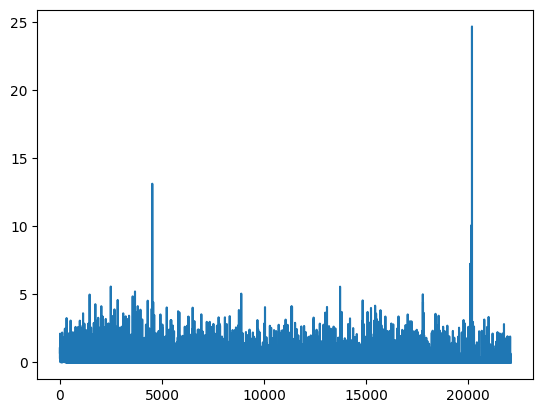

In [10]:
plt.plot(loss_list)

In [11]:
bc.eval()
train_x=torch.tensor(states).float()
train_y=torch.tensor(actions).long()
with torch.no_grad():
    y_pred = bc(train_x)
    correct = (torch.argmax(y_pred, dim=1) == train_y ).type(torch.FloatTensor)
    print('training accuracy: ', correct.mean())

training accuracy:  tensor(1.)


### Rollout

In [12]:
env_name = 'CartPole-v0'

In [13]:
def play_an_episode(env_name, model, video_path=None, max_steps=1000):
    video_writer=None 
    if video_path is not None:
        print(f'Saving video to {video_path}')
        video_writer = imageio.get_writer(video_path, fps=20)
        env=gym.make(env_name, render_mode='rgb_array')
    else:
        env=gym.make(env_name)

    obs,_=env.reset()
    rewards=0
    step=0
    for _ in range(max_steps):
        step+=1
        obs=torch.tensor(obs).float()
        predict=model(obs)
        action=torch.argmax(predict).item() 
        obs, reward, done, trunc,_ = env.step(action)

        if video_path is not None:
            image=env.render()
            video_writer.append_data(image)

        rewards+=reward
        if done or trunc:
            break

    if video_path is not None:
        video_writer.close()
    return {'reward':rewards, 'step':step-1}

In [14]:
scores=[]
n_trajectory=20
for i in range(n_trajectory):
    stats=play_an_episode(env_name, bc)
    rewards=stats['reward']
    print(f'episode #{i} reward: {rewards:0.2f}')
    scores.append(rewards)

print(f'\n score: {np.mean(scores):0.2f} +- {np.std(scores):0.2f}')

episode #0 reward: 10.00
episode #1 reward: 10.00
episode #2 reward: 10.00
episode #3 reward: 10.00
episode #4 reward: 27.00
episode #5 reward: 10.00
episode #6 reward: 78.00
episode #7 reward: 15.00
episode #8 reward: 10.00
episode #9 reward: 10.00
episode #10 reward: 10.00
episode #11 reward: 10.00
episode #12 reward: 19.00
episode #13 reward: 24.00
episode #14 reward: 23.00
episode #15 reward: 10.00
episode #16 reward: 10.00
episode #17 reward: 23.00
episode #18 reward: 11.00
episode #19 reward: 23.00

 score: 17.65 +- 15.09


### Let's render and save a video using the learned policy.

In [15]:
stats=play_an_episode(env_name, bc, video_path='bc_mc.mp4')
stats 

Saving video to bc_mc.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6f706c0] Warning: data is not aligned! This can lead to a speed loss


{'reward': 19.0, 'step': 18}

In [16]:
from IPython.display import Video
Video('bc_mc.mp4' )